# Question 2 - Product Category

## Define Question

Northwind sells a variety of consumer products including food items and beverages. If the company wants to maximize their average gross revenue, which categories of products should their sales team prioritize?

> Do some types of products bring in more gross revenue than others?

## State Hypothesis

**Null Hypothesis**: There is no difference between the average gross revenue across the categories of products.

> $H_{o}: \mu_1 = \mu_2 = ... = \mu_n$

**Alternative Hypothesis**: Category has a statistically significant effect on the average gross revenue.

> $H_{a}: \mu_1 < \mu_i$ 

**Significance Level**: 95% confidence level

> $\alpha = .05$

## Methodology

I load my data and calculate gross revenue for each order in the dataframe. After examining my data, I remove the outliers that would skew my results. I then run an ANOVA test and a Tukey test to determine which product categories have the highest average gross revenue.

## Import Libraries and Connect to Data Source

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from hypothesis_testing import bootstrap, create_sampling_distribution, remove_outliers, Cohen_d
import warnings
warnings.filterwarnings('ignore')
import itertools
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
#Connect to server and create cursor
conn = sqlite3.connect('northwind_small.sqlite')
c = conn.cursor()

## Obtain Data

In [3]:
query = """SELECT c.CategoryName, p.CategoryId, od.Quantity,
            ((od.Quantity*od.UnitPrice)*(1-od.Discount)) as GrossRevenue
            FROM OrderDetail od
            JOIN Product p
            ON od.ProductID == p.Id
            JOIN Category c
            ON c.Id == p.CategoryId"""

product_df = pd.read_sql(query, conn)
product_df.head()

,CategoryName,CategoryId,Quantity,GrossRevenue
0,Dairy Products,4,12,168.0
1,Grains/Cereals,5,10,98.0
2,Dairy Products,4,5,174.0
3,Produce,7,9,167.4
4,Produce,7,40,1696.0


In [4]:
product_df.describe()

,CategoryId,Quantity,GrossRevenue
count,2155.000000,2155.000000,2155.000000
mean,4.135499,23.812993,587.374960
std,2.378567,19.022047,969.224235
min,1.000000,1.000000,4.800000
25%,2.000000,10.000000,147.000000
50%,4.000000,20.000000,337.750000
75%,6.000000,30.000000,656.000000
max,8.000000,130.000000,15810.000000


## Scrub Data

In [5]:
# Remove outliers
p_df = remove_outliers(product_df, 'GrossRevenue')

p_df.describe()

,CategoryId,Quantity,GrossRevenue
count,2025.000000,2025.000000,2025.000000
mean,4.132346,21.819753,414.708449
std,2.392608,16.424567,361.516174
min,1.000000,1.000000,4.800000
25%,2.000000,10.000000,140.000000
50%,4.000000,20.000000,306.000000
75%,6.000000,30.000000,576.000000
max,8.000000,120.000000,1650.600000


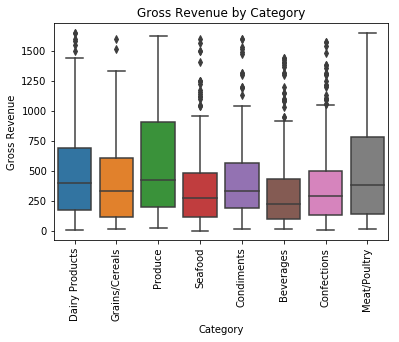

In [6]:
# Visualize data by discount level with boxplots
sns.boxplot(x='CategoryName', y='GrossRevenue', data=p_df)
plt.title('Gross Revenue by Category')
plt.xlabel('Category');
plt.ylabel('Gross Revenue')
plt.xticks(rotation='vertical')
plt.show()

## Hypothesis Testing

In [7]:
p_df.CategoryName.replace(to_replace='Dairy Products', value='Dairy_Products', inplace=True)
names = list(p_df.CategoryName.unique())
names


['Dairy_Products',
 'Grains/Cereals',
 'Produce',
 'Seafood',
 'Condiments',
 'Beverages',
 'Confections',
 'Meat/Poultry']

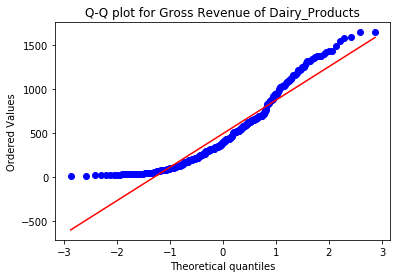

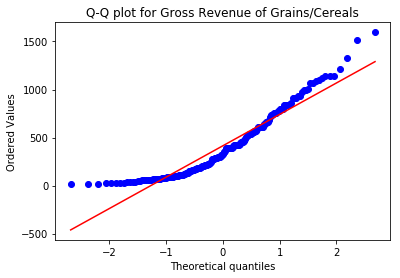

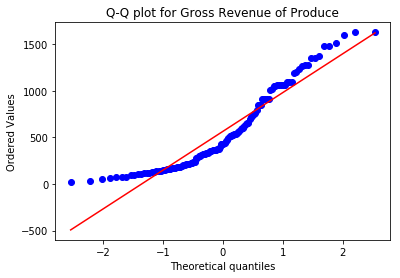

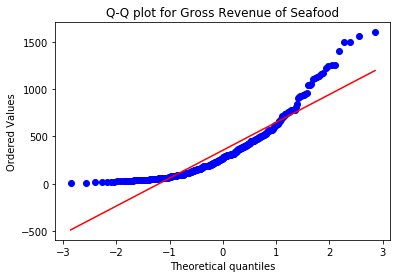

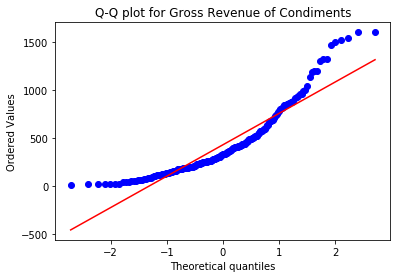

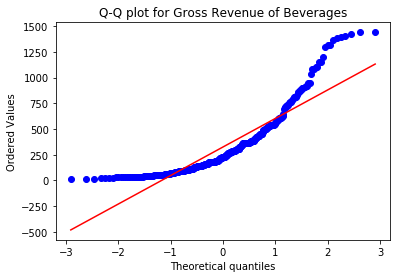

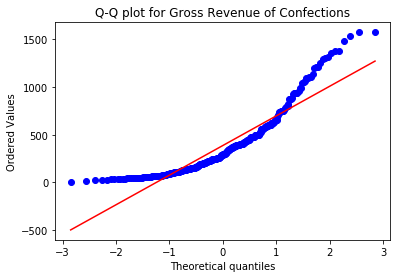

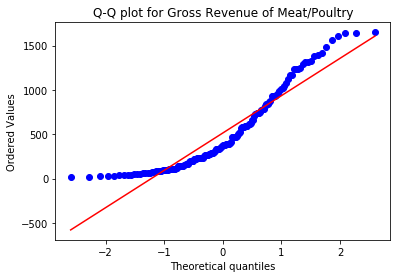

In [25]:
#Test normality
for n in names:
    stats.probplot(p_df['GrossRevenue'][p_df['CategoryName'] == n], dist="norm", plot=plt)
    plt.title("Q-Q plot for Gross Revenue of {}".format(n))
    plt.show()

In [9]:
p_df.CategoryName.value_counts()

Beverages         381
Dairy_Products    338
Seafood           322
Confections       316
Condiments        208
Grains/Cereals    189
Meat/Poultry      147
Produce           124
Name: CategoryName, dtype: int64

### Create Sampling Distribution

The original data does not satisfy the normality assumption required for my hypothesis test. To address this, I use a **sampling distribution**. According to the **Central Limit Theorem**, the distribution of sample means is normal regardless of the distribution of the actual population. 

In [10]:
p_df.shape

(2025, 4)

In [11]:
# Create the sampling distributions for every product category
category = []
index = []
gross_rev = []

for cat in list(p_df.CategoryName.values):
    for i in range(0,30):
        category.append(cat)
    a1 = list(p_df.GrossRevenue[(p_df.CategoryName == cat)].values)
    a2 = create_sampling_distribution(a1, 30, 30)
    index.append(a2)

for i in index:
    for e in i:
        gross_rev.append(e)
c1 = list(p_df.GrossRevenue.values)
c2 = create_sampling_distribution(c1, 30, 30)


In [12]:
display(len(category))
display(len(index))
display(len(gross_rev))

60750

2025

60750

In [13]:
# Make a DataFrame of all sampling distributions
samp_distributions = {}
samp_distributions['CategoryName'] = category
samp_distributions['Gross_Revenue'] = gross_rev
samp_distributions_df = pd.DataFrame(samp_distributions)

In [14]:
samp_distributions_df.Gross_Revenue.groupby(samp_distributions_df.CategoryName).describe()

,count,mean,std,min,25%,50%,75%,max
CategoryName,,,,,,,,
Beverages,11430.0,325.126726,53.423098,164.241500,287.315333,322.477583,360.053292,552.135000
Condiments,6240.0,431.368808,57.974198,247.895917,390.994646,429.531792,470.094208,672.893167
Confections,9480.0,386.379985,58.048501,185.641467,345.353321,384.002067,425.183500,617.754550
Dairy_Products,10140.0,492.585939,69.711739,275.166333,443.961875,490.748833,539.156667,790.078333
Grains/Cereals,5670.0,415.995125,56.551656,234.960000,377.275833,415.116667,453.485750,635.514167
Meat/Poultry,4410.0,514.517987,72.295361,298.803500,465.265725,513.733742,562.715571,788.566400
Produce,3720.0,566.250416,68.750212,354.556583,519.910958,564.016792,612.677729,816.664333
Seafood,9660.0,353.892531,54.662896,192.291667,315.578604,351.622000,390.451146,589.537667


### ANOVA Test

In [15]:
#ANOVA Test
formula = 'Gross_Revenue ~ C(CategoryName)'
model = ols(formula=formula, data=samp_distributions_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Gross_Revenue   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                 1.278e+04
Date:                Thu, 18 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:31:58   Log-Likelihood:            -3.3544e+05
No. Observations:               60750   AIC:                         6.709e+05
Df Residuals:                   60742   BIC:                         6.710e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           325.1267      0.566    574.431      0.000     324.017     326.236
C(CategoryName)[T.Condiments]       106.2421      0.952    111.547      0.000     104.375     108.109
C(CategoryName)[T.Confections]       61.2533      0.841     72.869      0.000      59.606      62.901
C(CategoryName)[T.Dairy_Products]   167.4592      0.826    202.856      0.000     165.841     169.077
C(CategoryName)[T.Grains/Cereals]    90.8684      0.983     92.447      0.000      88.942      92.795
C(CategoryName)[T.Meat/Poultry]     189.3913      1.073    176.558      0.000     187.289     191.494
C(CategoryName)[T.Produce]          241.1237      1.142    211.101      0.000     238.885     243.362
C(CategoryName)[T.Seafood]           28.7658      0.836     34.396      0.000      27.127      30.405
==============================================================================
Omnibus:                      415.497   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.295
Skew:                           0.192   Prob(JB):                     6.02e-94
Kurtosis:                       3.149   Cond. No.                         7.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
table = sm.stats.anova_lm(model, typ=2)
print(table)

                       sum_sq       df            F  PR(>F)
C(CategoryName)  3.276516e+08      7.0  12783.17813     0.0
Residual         2.224152e+08  60742.0          NaN     NaN


## Compare Levels of Discount

In [17]:
# TUKEY TEST
alpha = 0.05
mc = MultiComparison(p_df['GrossRevenue'], p_df['CategoryName'])
result = mc.tukeyhsd(alpha=alpha)

In [18]:
# Convert result to dataframe  
# Null hypothesis - the means are equal
tukey_df = pd.DataFrame(data=result._results_table.data[1:], 
                        columns=result._results_table.data[0])
print("Multiple Comparison of Means - Tukey HSD")
tukey_df

Multiple Comparison of Means - Tukey HSD


,group1,group2,meandiff,lower,upper,reject
0,Beverages,Condiments,105.8448,13.0817,198.6079,True
1,Beverages,Confections,61.1297,-20.7398,142.9993,False
2,Beverages,Dairy_Products,167.2979,86.8980,247.6978,True
3,Beverages,Grains/Cereals,89.2157,-6.5160,184.9474,False
4,Beverages,Meat/Poultry,189.2800,84.8061,293.7539,True
5,Beverages,Produce,239.1433,127.8973,350.3892,True
6,Beverages,Seafood,28.4758,-52.9757,109.9273,False
7,Condiments,Confections,-44.7151,-140.7883,51.3581,False
8,Condiments,Dairy_Products,61.4531,-33.3708,156.2771,False
9,Condiments,Grains/Cereals,-16.6291,-124.7587,91.5005,False


In [19]:
category_names = product_df['CategoryName'].unique()
category_names

array(['Dairy Products', 'Grains/Cereals', 'Produce', 'Seafood',
       'Condiments', 'Confections', 'Beverages', 'Meat/Poultry'],
      dtype=object)

In [20]:
category_combinations = itertools.combinations(category_names, 2)

In [21]:
# T-test for quantity average sales revenue per order from each region
category_sales_combo_df = pd.DataFrame(columns = ['Category 1','Category 2','p-value',
                                                      'Reject Null?', 'Category 1 Sales Mean', 'Category 2 Sales Mean',
                                                      'Difference of Means', 'Cohens d'])

for combo in category_combinations:
    
    samp1_control = p_df[p_df['CategoryName']==combo[0]]['GrossRevenue']
    samp2_experimental = p_df[p_df['CategoryName']==combo[1]]['GrossRevenue']
    
    s1mean = p_df[p_df['CategoryName']==combo[0]]['GrossRevenue'].mean()
    s2mean = p_df[p_df['CategoryName']==combo[1]]['GrossRevenue'].mean()
    
    t_stat, p_val = stats.ttest_ind(samp1_control, samp2_experimental)
    diff_mean = round(samp1_control.mean() - samp2_experimental.mean(),2)
    effect_size_cohen = round(Cohen_d(samp1_control, samp2_experimental),3)
    
    p_val = p_val / 2 # for one tailed test
    
    category_sales_combo_df = category_sales_combo_df.append({'Category 1' : combo[0], 'Category 2': combo[1], 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                           'Category 1 Sales Mean': s1mean, 'Category 2 Sales Mean': s2mean,
                                                 'Difference of Means': diff_mean, 'Cohens d': effect_size_cohen}, ignore_index=True)

In [22]:
category_sales_combo_df.head()

,Category 1,Category 2,p-value,Reject Null?,Category 1 Sales Mean,Category 2 Sales Mean,Difference of Means,Cohens d
0,Dairy Products,Grains/Cereals,NaN,"No, Fail to Reject",NaN,414.349669,NaN,NaN
1,Dairy Products,Produce,NaN,"No, Fail to Reject",NaN,564.277258,NaN,NaN
2,Dairy Products,Seafood,NaN,"No, Fail to Reject",NaN,353.609744,NaN,NaN
3,Dairy Products,Condiments,NaN,"No, Fail to Reject",NaN,430.978774,NaN,NaN
4,Dairy Products,Confections,NaN,"No, Fail to Reject",NaN,386.263718,NaN,NaN


In [23]:
category_sales_combo_df[category_sales_combo_df['Reject Null?'] == "Yes, Reject"]

,Category 1,Category 2,p-value,Reject Null?,Category 1 Sales Mean,Category 2 Sales Mean,Difference of Means,Cohens d
7,Grains/Cereals,Produce,3.460296e-04,"Yes, Reject",414.349669,564.277258,-149.93,0.397
8,Grains/Cereals,Seafood,2.104625e-02,"Yes, Reject",414.349669,353.609744,60.74,0.187
11,Grains/Cereals,Beverages,7.955106e-04,"Yes, Reject",414.349669,325.133976,89.22,0.283
12,Grains/Cereals,Meat/Poultry,9.693839e-03,"Yes, Reject",414.349669,514.413976,-100.06,0.259
13,Produce,Seafood,1.357563e-08,"Yes, Reject",564.277258,353.609744,210.67,0.600
14,Produce,Condiments,1.090747e-03,"Yes, Reject",564.277258,430.978774,133.30,0.351
15,Produce,Confections,2.549327e-06,"Yes, Reject",564.277258,386.263718,178.01,0.490
16,Produce,Beverages,1.347650e-11,"Yes, Reject",564.277258,325.133976,239.14,0.706
18,Seafood,Condiments,4.193342e-03,"Yes, Reject",353.609744,430.978774,-77.37,0.236
21,Seafood,Meat/Poultry,4.600518e-06,"Yes, Reject",353.609744,514.413976,-160.80,0.447


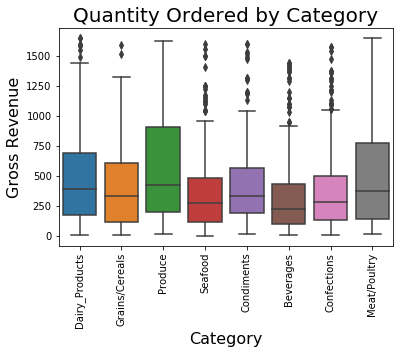

In [24]:
# Visualize data by discount level with boxplots
sns.boxplot(x='CategoryName', y='GrossRevenue', data=p_df)
plt.title('Quantity Ordered by Category', fontsize = 20)
plt.xlabel('Category', fontsize = 16)
plt.ylabel('Gross Revenue', fontsize = 16)
plt.xticks(rotation='vertical')
plt.show()

## Results

The two categories that bring in the highest average gross revenue are Meat/Poultry and Produce. Beverages have the lowest average gross revenue but also the most outliers. Seafood also had low average gross revenue. The largest effect size is between Produce and Beverages.

## Recommendations

I recommend that Northwinds focus their sales efforts toward products in the categories of Produce and Meat/Poultry as these categories bring in the highest average gross revenue. 